In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
torch.cuda.empty_cache()

In [4]:
#set seed
torch.manual_seed(1)#https://pytorch.org/docs/stable/notes/randomness.html

In [5]:
#check if using CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [23]:
non_research = 0#using non-research-grade images

In [6]:
#remove files
import os
 
dir = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/Flowers"
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
    
dir = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/NoFlowers"
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [7]:
#copy files -- Flowers, Eucalyptus
import glob
import os.path
import shutil

SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Eucalyptus/Flowers"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/Flowers"

GLOB_PARMS = "*.jpeg" #maybe "*.pdf" ?

for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))
        # This is just a print command that outputs to console that the
        # file was already in directory

In [8]:
#copy files -- NoFlowers, Eucalyptus
SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Eucalyptus/NoFlowers"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/NoFlowers"

for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))

In [9]:
##copy files -- Flowers , Angophora
SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Angophora/Flowers"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/Flowers"
for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))

In [10]:
#copy files -- NoFlowers, Angophora
SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Angophora/NoFlowers"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/NoFlowers"

for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))

In [11]:
##copy files -- Flowers , Corymbia
SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Corymbia/Flowers"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/Flowers"
for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))

In [12]:
#copy files -- NoFlowers, Corymbia
SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Corymbia/NoFlowers"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/NoFlowers"

for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))

In [13]:

if non_research == 1:
    #copy files -- NoFlowers, combined-winter-non-research-grade
    SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/combined-winter-non-research-grade/NoFlowers"#
    TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/NoFlowers"

    for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
        if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
            shutil.copy(file,TARG_DIR)
        else:
            print("{} exists in {}".format(
                file,os.path.join(os.path.split(TARG_DIR)[-2:])))
    #copy files -- Flowers, combined-winter-non-research-grade
    SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/combined-winter-non-research-grade/Flowers"#
    TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/input_folder/Flowers"

    for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
        if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
            shutil.copy(file,TARG_DIR)
        else:
            print("{} exists in {}".format(
                file,os.path.join(os.path.split(TARG_DIR)[-2:])))

In [ ]:
#manually delete val and train folders if they exist

In [14]:
import splitfolders  # or import split_folders

#may need to manually delete train and val
dir = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/output"
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("data/flowers_data/input_folder", output="data/flowers_data/output", seed=1337, ratio=(.8, 0.2), group_prefix=None) # default values

Copying files: 1434 files [00:04, 320.66 files/s]


In [15]:
#manually make Unlabeled folder within /output and put Unlabeled images into output/Unlabeled/Flowers 
#as workaround so standard ImageFolder + dataset + dataloader works for making predictions
import os
if not os.path.exists('data/flowers_data/output/Unlabeled'):
    os.makedirs('data/flowers_data/output/Unlabeled')

if not os.path.exists('data/flowers_data/output/Unlabeled/Flowers'):
    os.makedirs('data/flowers_data/output/Unlabeled/Flowers')

In [16]:
#load unlabeled images
#copy files -- Eucalyptus
import glob
import os.path
import shutil

SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Eucalyptus/Unlabeled"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/output/Unlabeled/Flowers"

GLOB_PARMS = "*.jpeg" #

files_copied = 0
for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
        files_copied +=1
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))
        # This is just a print command that outputs to console that the
        # file was already in directory
        
print(files_copied)

4961


In [17]:
#copy files -- Corymbia
import glob
import os.path
import shutil

SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Corymbia/Unlabeled"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/output/Unlabeled/Flowers"

GLOB_PARMS = "*.jpeg" #

files_copied = 0
for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
        files_copied +=1
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))
        # This is just a print command that outputs to console that the
        # file was already in directory
        
print(files_copied)

525


In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Unlabeled': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data/flowers_data/output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'Unlabeled']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)#tried with pin_memory = True and didn't go any faster
                  for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
#making weighting even tho' not using it because it gives super low accuracy 
from os import listdir
from os.path import isfile, join

dataset_sizes_train = []

mypath = 'data/flowers_data/output/train/Flowers'
flowerfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] 
fnames= sorted(flowerfiles)
num_flower_train = len(fnames)
dataset_sizes_train.append(num_flower_train)

mypath = 'data/flowers_data/output/train/NoFlowers'
noflowerfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] 
fnames= sorted(noflowerfiles)
num_noflower_train = len(fnames)

dataset_sizes_train.append(num_noflower_train)

print(dataset_sizes_train)
###weighted resampling
class_sample_count = dataset_sizes_train # dataset has 10 class-1 samples, 1 class-2 samples, etc.
weights = 1 / torch.Tensor(class_sample_count)
print(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples = len(class_sample_count), replacement=True)

dataloaders_weighted = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=4, sampler = sampler)#tried with pin_memory = True and didn't go any faster
                  for x in ['train', 'val']}


[161, 985]
tensor([0.0062, 0.0010])


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



In [8]:
#get dataset sizes and class-to-number matchup
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("dataset sizes")
print(dataset_sizes)

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_class_name_number_matchup = datasets.ImageFolder('data/flowers_data/output/val', transform=data_transforms)
print(dataset_class_name_number_matchup.class_to_idx)#https://discuss.pytorch.org/t/how-to-get-the-class-names-to-class-label-mapping/470

dataset sizes
{'train': 1146, 'val': 288}
{'Flowers': 0, 'NoFlowers': 1}


Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [9]:
import pandas as pd

#dataloaders: specify dataloader function
def train_model(model, criterion, optimizer, scheduler, dataloaders, model_name, num_epochs=25):
    epoch_list = []#adding this -- save outputs without tensorboard 
    phase_list = []#adding this -- save outputs without tensorboard
    loss_list = []#adding this 
    accuracy_list = []#adding this
    # dictionary of lists  
    dict_performance = {'epoch': epoch_list, 'phase': phase_list, 'loss': loss_list, 'accuracy': accuracy_list}
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    best_epoch = []#added

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
            epoch_list.append(epoch)#adding this 
            phase_list.append(phase)#adding this 
            loss_list.append(epoch_loss)#added
            accuracy_list.append(epoch_acc.data.cpu().numpy())#added

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    df = pd.DataFrame(dict_performance) #added this
    # saving the dataframe 
    df.to_csv('results/finetuning/model_performance_' + model_name + '.csv') #added this

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [16]:
import time
start = time.time()#see how long this takes

model_ft = train_model(model_ft, criterion, optimizer_ft, 
                       exp_lr_scheduler,
                       dataloaders = dataloaders,
                       model_name = 'ft',
                       num_epochs=25)#original: 25

end = time.time()
print("time in seconds")
print(end - start)

Epoch 0/24
----------


C:\Users\fischhoffi\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.3489 Acc: 0.8770
val Loss: 0.1975 Acc: 0.9444

Epoch 1/24
----------
train Loss: 0.2675 Acc: 0.9119
val Loss: 0.2385 Acc: 0.9549

Epoch 2/24
----------
train Loss: 0.2687 Acc: 0.9119
val Loss: 0.1683 Acc: 0.9653

Epoch 3/24
----------
train Loss: 0.2105 Acc: 0.9354
val Loss: 0.1741 Acc: 0.9444

Epoch 4/24
----------
train Loss: 0.2471 Acc: 0.9276
val Loss: 0.1187 Acc: 0.9653

Epoch 5/24
----------
train Loss: 0.2013 Acc: 0.9407
val Loss: 0.1496 Acc: 0.9549

Epoch 6/24
----------
train Loss: 0.2185 Acc: 0.9346
val Loss: 0.3929 Acc: 0.8611

Epoch 7/24
----------
train Loss: 0.1667 Acc: 0.9459
val Loss: 0.1188 Acc: 0.9757

Epoch 8/24
----------
train Loss: 0.1534 Acc: 0.9572
val Loss: 0.1336 Acc: 0.9549

Epoch 9/24
----------
train Loss: 0.1371 Acc: 0.9581
val Loss: 0.1399 Acc: 0.9549

Epoch 10/24
----------
train Loss: 0.1571 Acc: 0.9564
val Loss: 0.1167 Acc: 0.9722

Epoch 11/24
----------
train Loss: 0.1299 Acc: 0.9590
val Loss: 0.1234 Acc: 0.9549

Epoch 12/24
----------
t

In [17]:
#save model so we don't need to re-run again
model_pt_name = 'results/finetuning/model_ft.pt'
model_model_name = 'results/finetuning/model_ft_full.pt'

In [18]:
torch.save(model_ft.state_dict(), model_pt_name)
torch.save(model_ft, model_model_name)

In [20]:
model_ft_loaded = torch.load(model_model_name)
type(model_ft_loaded)
#this part is not working -- shape mismatch
#model_ft_init = models.resnet18(pretrained=True, num_classes = 2)
#load model
#model_ft_init.load_state_dict(torch.load(model_path_name))

torchvision.models.resnet.ResNet

In [21]:
#remove some fields from csv file that has metadata for each iNat record
csvfile_orig = 'data/flowers_data/get_images/iNaturalistEucalypts - iNaturalistEucalypts.csv'

df = pd.read_csv(csvfile_orig)#read in csv into dataframe

df.columns

df = df[['scientific_name', 'datetime', 'latitude',
       'longitude', 'url', 'image_url', 'id', 'taxon_id',
 'observed_on', 'time_observed_at', 
       'positional_accuracy', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'user_id', 'created_at', 'updated_at',
       'quality_grade', 'license',
       'captive_cultivated', 'genus']]
csvfile = 'data/flowers_data/get_images/iNatEucalypts_brief.csv'
df.to_csv(csvfile, index = False)

In [24]:
#if we include non-research then we need to add metadata to iNatEucalypts_brief.csv
if non_research == 1:
    print("add non-research metatada")

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [26]:
dataloaders_no_shuffle_single = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False, num_workers=4)#tried with pin_memory = True and didn't go any faster
                  for x in [ 'val']}
import os 
from os import listdir
from os.path import isfile, join

def visualize_model_no_shuffle_single(model, mypath, csvfile):
    image_counter = 0
    id = []
    predicted = []
    true = []
    dict_pred_true = {'id': id, 'predicted': predicted, 'true': true}

    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] 
    fnames= sorted(onlyfiles)
    num_images = len(fnames)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    df = pd.read_csv(csvfile)#read in csv into dataframe
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_no_shuffle_single['val']):
            image_counter +=1
            print("running count of images")
            print(image_counter)
            print(fnames[image_counter -1])#go back one for indexing to print file name
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            id_temp = os.path.splitext(fnames[i])[0]
            id.append(id_temp)#add this id 
            true_temp = labels.data.cpu().numpy()
            true.append(true_temp.item())
            print("true label number")
            true_temp = true_temp.astype(int)[0]
            print(true_temp)
            print("true label word")
            print(class_names[true_temp])
            for j in range(inputs.size()[0]):
                images_so_far += 1
                print("predicted num")
                print(preds[j].item())
                print('predicted: {}'.format(class_names[preds[j]]))
                if preds[j].item() != true_temp:
                    print("WRONG PREDICTION")
                preds_out = preds[j].data.cpu().numpy()
                predicted.append(preds_out)#add predicted

                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    df_tmp = pd.DataFrame(dict_pred_true)
                    df_tmp.to_csv('results/finetuning/pred_true_val_flowers.csv', index = False) #added this
                    return                    
        model.train(mode=was_training)

running count of images
1
1121251.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


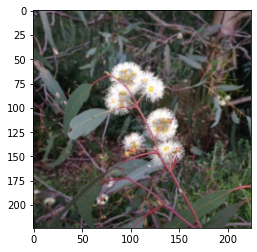

running count of images
2
14029370.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


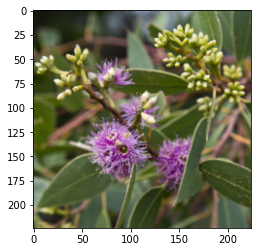

running count of images
3
16372066.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


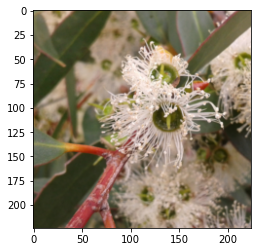

running count of images
4
18044124.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


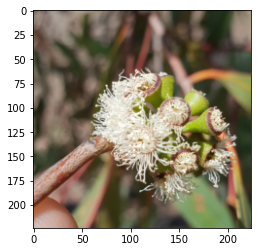

running count of images
5
18969220.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


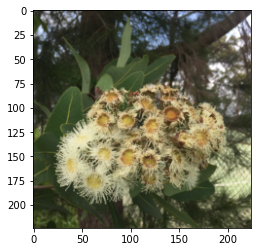

running count of images
6
18969922.jpeg
true label number
0
true label word
Flowers
predicted num
1
predicted: NoFlowers
WRONG PREDICTION


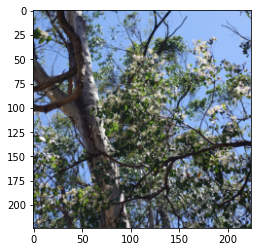

running count of images
7
19777656.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


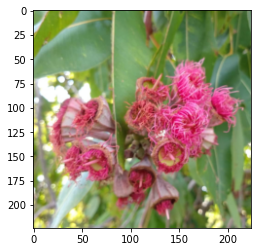

running count of images
8
21538881.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


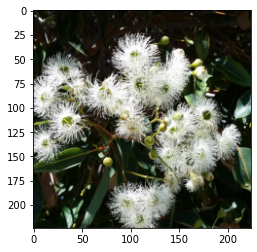

running count of images
9
30718416.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


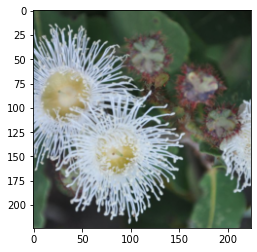

running count of images
10
33105034.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


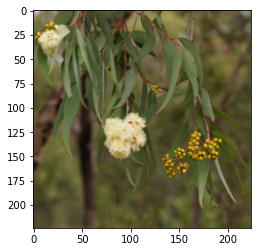

running count of images
11
34820718.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


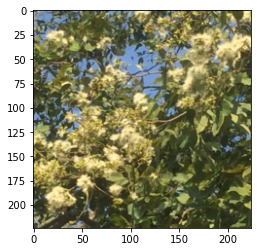

running count of images
12
36523835.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


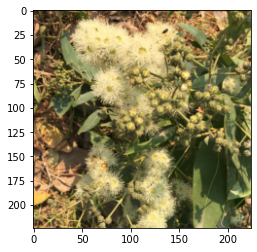

running count of images
13
36963933.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


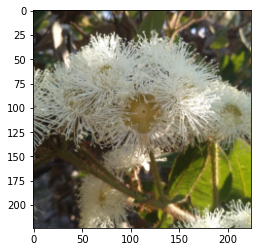

running count of images
14
37045976.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


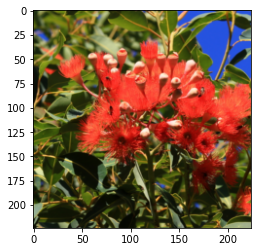

running count of images
15
37091839.jpeg
true label number
0
true label word
Flowers
predicted num
1
predicted: NoFlowers
WRONG PREDICTION


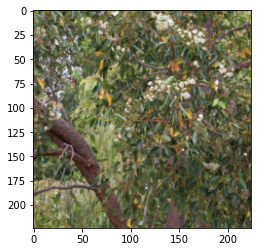

running count of images
16
37127594.jpeg
true label number
0
true label word
Flowers
predicted num
1
predicted: NoFlowers
WRONG PREDICTION


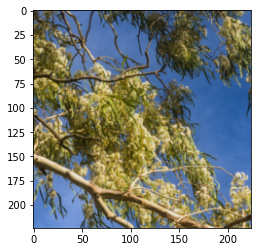

running count of images
17
37605266.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


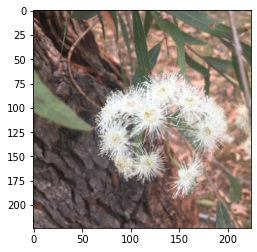

running count of images
18
37839763.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


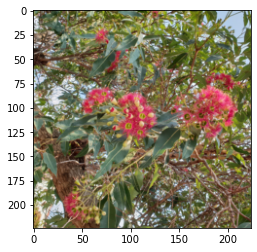

running count of images
19
37963286.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


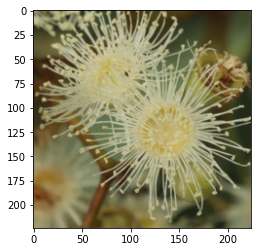

running count of images
20
37984002.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


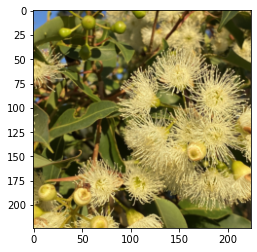

running count of images
21
38177779.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


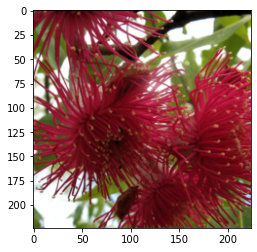

running count of images
22
39481064.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


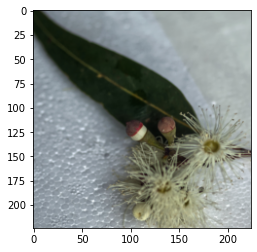

running count of images
23
47709671.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


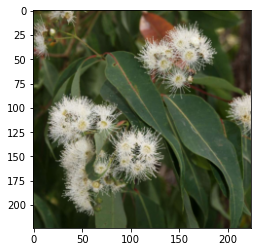

running count of images
24
51201053.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


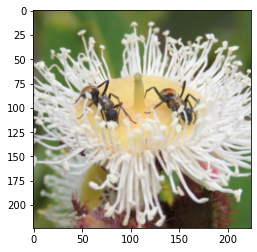

running count of images
25
64637511.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


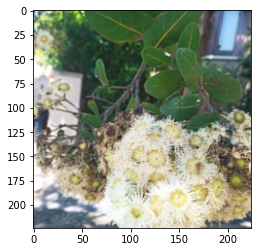

running count of images
26
65516314.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


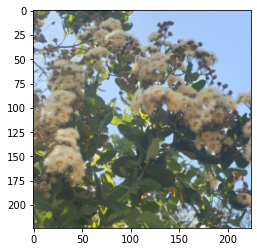

running count of images
27
66113118.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


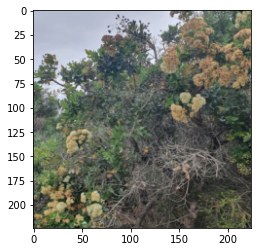

running count of images
28
66456279.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


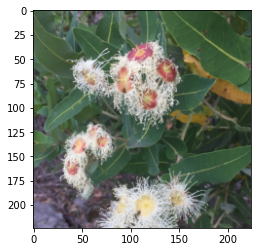

running count of images
29
66620609.jpeg
true label number
0
true label word
Flowers
predicted num
1
predicted: NoFlowers
WRONG PREDICTION


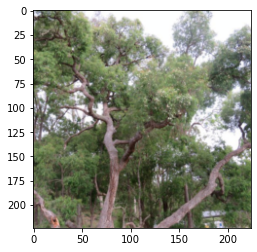

running count of images
30
6715031.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


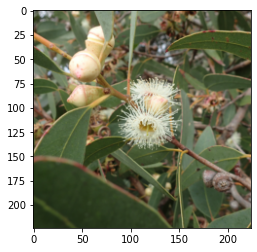

running count of images
31
67210909.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


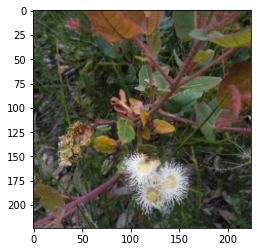

running count of images
32
67290818.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


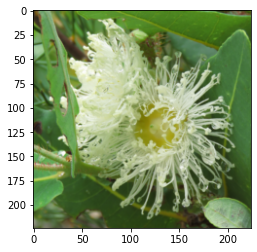

running count of images
33
67292591.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


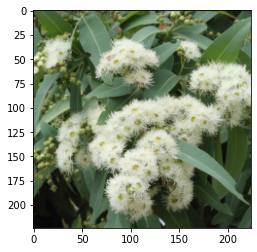

running count of images
34
67652827.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


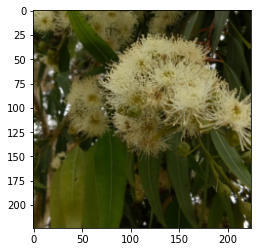

running count of images
35
67729100.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


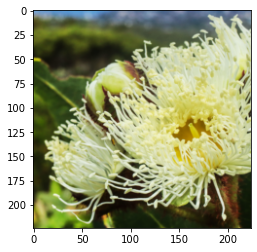

running count of images
36
68383515.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


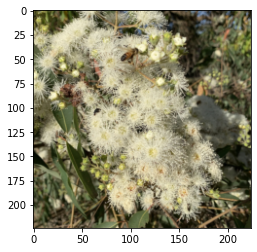

running count of images
37
69075252.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


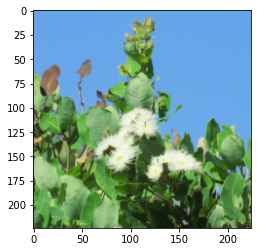

running count of images
38
70133778.jpeg
true label number
0
true label word
Flowers
predicted num
1
predicted: NoFlowers
WRONG PREDICTION


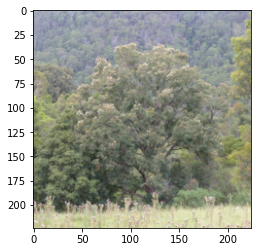

running count of images
39
7655853.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


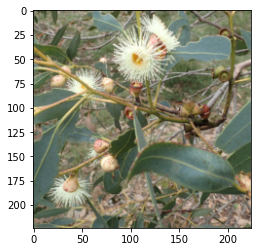

running count of images
40
852467.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


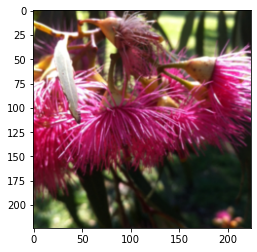

running count of images
41
9391077.jpeg
true label number
0
true label word
Flowers
predicted num
0
predicted: Flowers


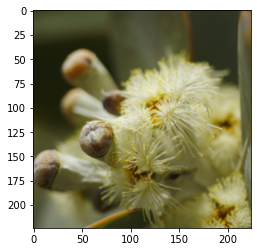

In [27]:
#find out what happens if we sort filenames in val folder
mypath = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/output/val/Flowers"
visualize_model_no_shuffle_single(model_ft, mypath = mypath, csvfile = csvfile)

In [28]:
#match up predictions, labels, and brief version of original iNat metadata for validation flower data
df_model = pd.read_csv('results/finetuning/pred_true_val_flowers.csv')
df = pd.read_csv(csvfile)

df.shape
df_merge = pd.merge(df_model, df, on = "id")
df_merge.shape
df_merge['id']
df = df_merge

shape_tmp = df.shape
list_compare = []
list_compare_temp = np.repeat(-9999, shape_tmp[0])#make array
#get what predictions are same as true label and which are different
index_list_different = []
index_list_same = []
for index, row in df.iterrows():
    if row['predicted'] != row['true']:
        index_list_different.append(index)
    else:
        index_list_same.append(index)
list_compare_temp[index_list_different] = 1
list_compare_temp[index_list_same] = 0
list_compare.extend(list_compare_temp)#add to long list
df['wrong_prediction']= list_compare
df.to_csv('results/finetuning/val_flowers_iNat_data.csv', index = False) #added this                  

In [29]:
#graph loss over epochs
import altair as alt
import pandas as pd
df = pd.read_csv('results/finetuning/model_performance.csv')#read in csv into dataframe
df.drop(columns=['Unnamed: 0'])
df_loss= df.drop(columns=['accuracy'])
df_loss
df_accuracy = df.drop(columns =['loss'])
#make graph of loss by epoch
alt.Chart(df_loss).mark_line().encode(
  x='epoch:T',
  y='loss:Q',
  color='phase:N'
)

alt.Chart(...)

In [30]:
#make graph of accuracy by epoch
alt.Chart(df_accuracy).mark_line().encode(
  x='epoch:T',
  y='accuracy:Q',
  color='phase:N'
)

alt.Chart(...)

In [31]:
#confusion matrix
#source: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft(inputs) # Feed Network

            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
        
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

[[ 36   5]
 [  1 246]]


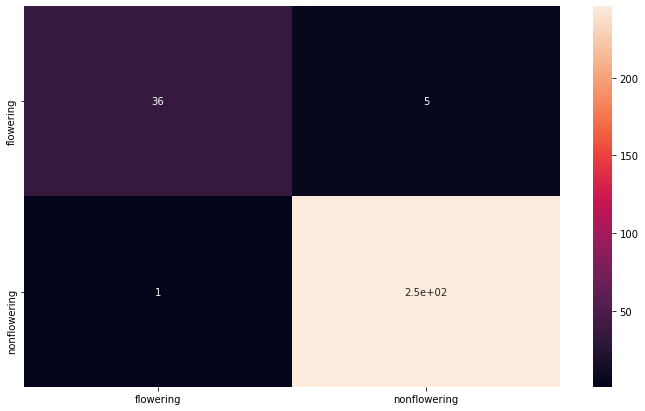

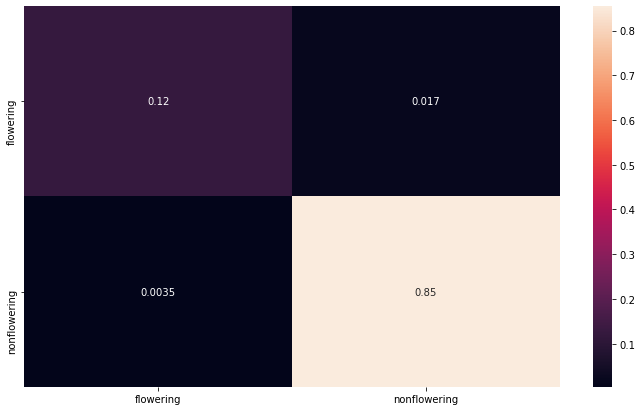

In [45]:
#graph confusion matrix
# Build confusion matrix
classes = ('flowering', 'nonflowering')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cf_matrix = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

#make graph for counts
plt.figure(figsize = (12,7))
sn.heatmap(df_cf_matrix, annot=True)
plt.savefig('results/finetuning/confusion_counts.png')

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('results/finetuning/confusion_fraction.png')
print(cf_matrix)

Make predictions for unlabeled images

In [46]:
#organize unlabeled images
#copy files -- Corymbia
import glob
import os.path
import shutil

SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Corymbia/Unlabeled"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/output/Unlabeled/Flowers"

GLOB_PARMS = "*.jpeg" #

files_copied = 0
for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
        files_copied +=1
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))
        # This is just a print command that outputs to console that the
        # file was already in directory
        
print(files_copied)

525


In [47]:
#organize unlabeled images
#copy files -- Eucalyptus
import glob
import os.path
import shutil

SRC_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/get_images/Eucalyptus/Unlabeled"#these were downloaded using R with labeled IDs in Eucalypts.xls on 8/16/21
TARG_DIR = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/output/Unlabeled/Flowers"

GLOB_PARMS = "*.jpeg" #

files_copied = 0
for file in glob.glob(os.path.join(SRC_DIR, GLOB_PARMS)):
    if file not in glob.glob(os.path.join(TARG_DIR, GLOB_PARMS)):
        shutil.copy(file,TARG_DIR)
        files_copied +=1
    else:
        print("{} exists in {}".format(
            file,os.path.join(os.path.split(TARG_DIR)[-2:])))
        # This is just a print command that outputs to console that the
        # file was already in directory
        
print(files_copied)

4961


In [32]:
#make function to make predictions
import os 
from os import listdir
from os.path import isfile, join

#make dataloader just for unlabeled images that are in their own folder
dataloaders_unlabeled = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False, num_workers=4)#tried with pin_memory = True and didn't go any faster
                  for x in [ 'Unlabeled']}

def predict_unlabeled(model, unlabeled_path, csvfile, cutoff = 100):
    image_counter = 0
    id = []
    predicted = []
    dict_pred = {'id': id, 'predicted': predicted}

    onlyfiles = [f for f in listdir(unlabeled_path) if isfile(join(unlabeled_path, f))] 
    fnames= sorted(onlyfiles)
    num_images = len(fnames)
    #if num_images < 1000:
    #    cutoff = 100
    #else:
    #    cutoff = 500
    was_training = model.training
    model.eval()
    images_so_far = 0
    df = pd.read_csv(csvfile)#read in csv into dataframe
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_unlabeled['Unlabeled']):
            image_counter +=1
            
            if image_counter % cutoff == 0:
                perc_done = round(100*image_counter/num_images)
                print("% of images done")
                print(perc_done)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            id_temp = os.path.splitext(fnames[i])[0]
            id.append(id_temp)#add this id 
            for j in range(inputs.size()[0]):
                preds_out = preds[j].data.cpu().numpy()
                predicted.append(preds_out)#add predicted

                if image_counter % cutoff == 0:#only show every 1000th image 
                    print(fnames[image_counter -1])#go back one for indexing
                    print("predicted num")
                    print(preds[j].item())
                    print('predicted: {}'.format(class_names[preds[j]]))
                    imshow(inputs.cpu().data[j])
                    
                images_so_far += 1
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    df_tmp = pd.DataFrame(dict_pred)
                    df_tmp.to_csv('results/finetuning/predict_unlabeled.csv', index = False) #added this
                    return 
                    
        model.train(mode=was_training)


data/flowers_data/get_images/iNatEucalypts_brief.csv
% of images done
5
28666297.jpeg
predicted num
1
predicted: NoFlowers


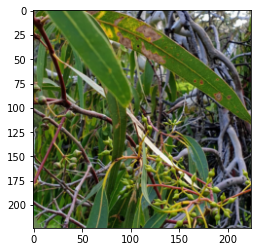

% of images done
9
34481681.jpeg
predicted num
0
predicted: Flowers


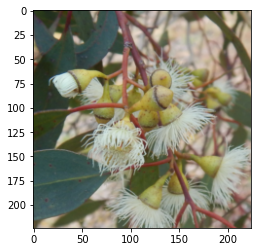

% of images done
14
36585125.jpeg
predicted num
1
predicted: NoFlowers


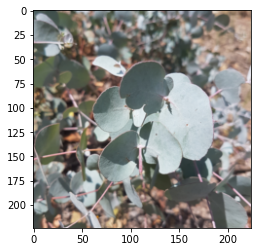

% of images done
18
38601211.jpeg
predicted num
1
predicted: NoFlowers


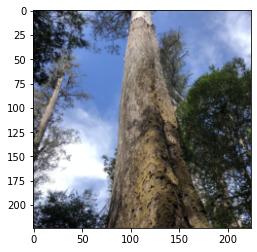

% of images done
23
41793834.jpeg
predicted num
1
predicted: NoFlowers


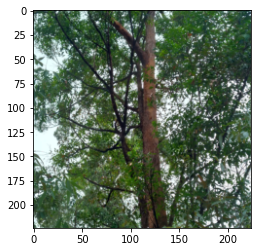

% of images done
27
43046470.jpeg
predicted num
1
predicted: NoFlowers


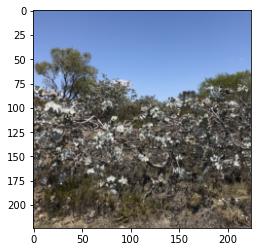

% of images done
32
44455655.jpeg
predicted num
1
predicted: NoFlowers


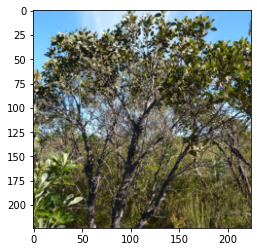

% of images done
36
46650811.jpeg
predicted num
0
predicted: Flowers


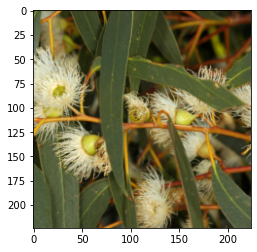

% of images done
41
49560906.jpeg
predicted num
0
predicted: Flowers


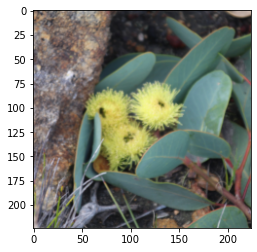

% of images done
46
54044736.jpeg
predicted num
1
predicted: NoFlowers


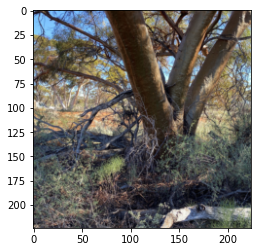

% of images done
50
57301032.jpeg
predicted num
1
predicted: NoFlowers


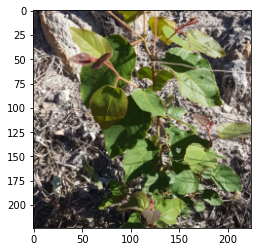

% of images done
55
60368680.jpeg
predicted num
1
predicted: NoFlowers


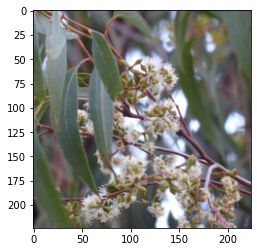

% of images done
59
62278115.jpeg
predicted num
1
predicted: NoFlowers


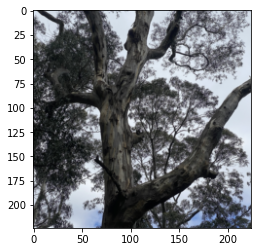

% of images done
64
65456213.jpeg
predicted num
1
predicted: NoFlowers


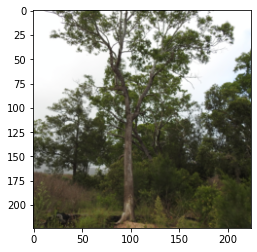

% of images done
68
67904815.jpeg
predicted num
1
predicted: NoFlowers


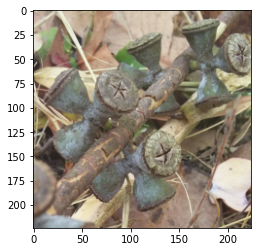

% of images done
73
69659852.jpeg
predicted num
0
predicted: Flowers


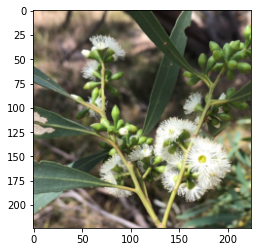

% of images done
77
71910538.jpeg
predicted num
0
predicted: Flowers


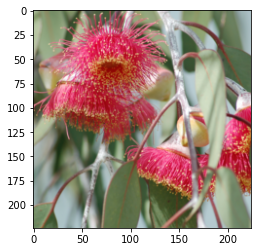

% of images done
82
73830673.jpeg
predicted num
0
predicted: Flowers


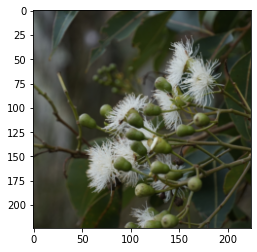

% of images done
87
76047062.jpeg
predicted num
1
predicted: NoFlowers


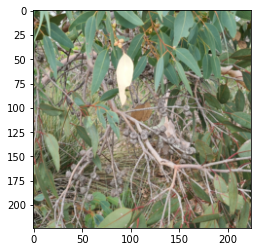

% of images done
91
78957965.jpeg
predicted num
1
predicted: NoFlowers


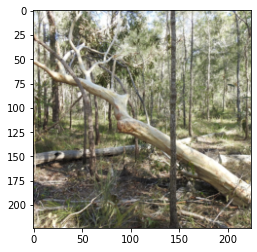

% of images done
96
82256854.jpeg
predicted num
0
predicted: Flowers


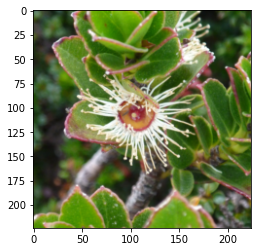

In [33]:
#run function to make predictions for unlabeled images
unlabeled_path = "C:/Users/fischhoffi/Documents/pytorch/data/flowers_data/output/Unlabeled/Flowers"
print(csvfile)
predict_unlabeled(model_ft, unlabeled_path = unlabeled_path, csvfile = csvfile, cutoff = 250)
#For images shown by this, take ID from filename and load observation page for this record to confirm images are same

In [64]:
#match up predictions for unlabeled and brief version of original iNat metadata
df_predicted = pd.read_csv('results/finetuning/predict_unlabeled.csv')
df = pd.read_csv(csvfile)#iNat data

print(df_predicted.shape)
df_merge = pd.merge(df_predicted, df, on = "id")
print(df_merge.shape)
df = df_merge

df['wrong_prediction'] = -9999
df['class']=df['predicted']
df.to_csv('results/finetuning/predict_unlabeled_iNat.csv', index = False) #added this 
df.columns

(5486, 2)
(5486, 23)


Index(['id', 'predicted', 'scientific_name', 'datetime', 'latitude',
       'longitude', 'url', 'image_url', 'taxon_id', 'observed_on',
       'time_observed_at', 'positional_accuracy', 'public_positional_accuracy',
       'geoprivacy', 'taxon_geoprivacy', 'coordinates_obscured', 'user_id',
       'created_at', 'updated_at', 'quality_grade', 'license',
       'captive_cultivated', 'genus', 'wrong_prediction', 'class'],
      dtype='object')

In [95]:
#put together train and validation IDs with iNat metadata  
#get filenames of train flower data 
class_num = 0 #Flowers

mypath = 'data/flowers_data/output/train/Flowers'
fnames = [f for f in listdir(mypath) if isfile(join(mypath, f))] 
print(len(fnames))
mypath = 'data/flowers_data/output/val/Flowers'
fnames_val = [f for f in listdir(mypath) if isfile(join(mypath, f))] 
fnames.extend(fnames_val)
print(len(fnames))

id_names = []    
i = 201#202 out of bounds
last_ind = len(fnames)-1
for index in range(0, last_ind):
    id_names.append(os.path.splitext(fnames[index])[0])
    
dict_flower = {'id': id_names}
dict_flower['class']=class_num
dict_flower['class_name']= class_names[class_num]

dict_flower['predicted']=-9999
dict_flower['wrong_prediction']=-9999
df = pd.DataFrame(dict_flower)
df['id'] = df['id'].astype(str).astype(int)
print(df.shape)
csvfile = 'data/flowers_data/get_images/iNatEucalypts_brief.csv'
df_iNat = pd.read_csv(csvfile)
#print(df_iNat.shape)

type(df['id'])
id_all = df_iNat['id']
id_all = id_all.reset_index(drop=True)
#== s2.reset_index(drop=True)

id_1 = df['id']
id_1 = id_1.reset_index(drop=True)

#id_all[id_all.isin(id_1) == False]
print("items in id_1 that are not in id_all")
print(id_1[id_1.isin(id_all) == False])

df = pd.merge(df, df_iNat, on = "id")
print(df.shape)#seem to have lost one
df.to_csv('results/finetuning/temp_train_val_' +class_names[class_num] + '.csv', index = False)
print(class_names[class_num])

161
202
(201, 5)
items in id_1 that are not in id_all
Series([], Name: id, dtype: int32)
(201, 26)
Flowers


In [96]:
#put together train and validation IDs with iNat metadata  
#get filenames of train moflower data 
class_num = 1 #NoFlowers

mypath = 'data/flowers_data/output/train/' + class_names[class_num]
fnames = [f for f in listdir(mypath) if isfile(join(mypath, f))] 
print(len(fnames))
mypath = 'data/flowers_data/output/val/'  + class_names[class_num]
fnames_val = [f for f in listdir(mypath) if isfile(join(mypath, f))] 
fnames.extend(fnames_val)
print(len(fnames))

id_names = []    
i = 201#202 out of bounds
last_ind = len(fnames)-1
for index in range(0, last_ind):
    id_names.append(os.path.splitext(fnames[index])[0])
    
dict_flower = {'id': id_names}
dict_flower['class']=class_num
dict_flower['class_name']= class_names[class_num]

dict_flower['predicted']=-9999
dict_flower['wrong_prediction']=-9999
df = pd.DataFrame(dict_flower)
df['id'] = df['id'].astype(str).astype(int)
print(df.shape)
csvfile = 'data/flowers_data/get_images/iNatEucalypts_brief.csv'
df_iNat = pd.read_csv(csvfile)

df = pd.merge(df, df_iNat, on = "id")
print(df.shape)#seem to have lost one
df.to_csv('results/finetuning/temp_train_val_' +class_names[class_num] + '.csv', index = False)
print(class_names[class_num])

985
1232
(1231, 5)
(1231, 26)
NoFlowers


In [100]:
#put together train and val Flower and NoFlower data
class_num = 0
df_0 = pd.read_csv('results/finetuning/temp_train_val_' +class_names[class_num] + '.csv')
class_num = 1
df_1 = pd.read_csv('results/finetuning/temp_train_val_' +class_names[class_num] + '.csv')
df = df_0.append(df_1)
df['how_labeled'] = 'person'
df.to_csv('results/finetuning/person_labeled_iNat_data.csv', index = False)

In [137]:
#put together person-labeled and model-predicted data
df_model = pd.read_csv('results/finetuning/predict_unlabeled_iNat.csv')
#add class name
class_names_temp = []
for index in range(0, df_model.shape[0]):
    #class_names_temp.append(df_model['predicted'][index])
    #print(type(df_model['predicted'][index].item()))
    if df_model['predicted'][index]== 0:
        class_names_temp.append(class_names[0])
    elif df_model['predicted'][index]== 1:
        class_names_temp.append(class_names[1])
    else:
        class_names_temp.append(-9999)

df_model['class_name']=class_names_temp
df_model['how_labeled']='model'

print(df_model.shape)
df_model_col = df_model.columns
df_person = pd.read_csv('results/finetuning/person_labeled_iNat_data.csv')
print(df_person.shape)
df_person_col = df_person.columns
print("columns in df_model that are not in df_person")
print(df_model_col[df_model_col.isin(df_person_col) == False])

print("columns in df_person that are not in df_model")
print(df_person_col[df_person_col.isin(df_model_col) == False])

df = df_person.append(df_model)
df = df.drop(columns = ['wrong_prediction'])
df.to_csv('results/finetuning/person_model_iNat.csv', index = False)

(5486, 27)
(1432, 27)
columns in df_model that are not in df_person
Index([], dtype='object')
columns in df_person that are not in df_model
Index([], dtype='object')


Finetuning model using weighted resampling 

In [ ]:
#this does not seem to work, stochastically fails
#start = time.time()#see how long this takes

#model_ft_wt = train_model(model_ft, criterion, optimizer_ft, 
#                          exp_lr_scheduler, 
#                          dataloaders = dataloaders_weighted,
#                          model_name = 'ft_wt',
#                       num_epochs=25)#original: 25

#end = time.time()
#print("time in seconds")
#print(end - start)

Fine-tuning with unfreezing half the layers

In [ ]:
model_1 = models.resnet18(pretrained=True)
ct = 0
for child in model_1.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            param.requires_grad = False
            
num_ftrs = model_1.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_1.fc = nn.Linear(num_ftrs, 2)

model_1 = model_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_1 = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)

In [ ]:
#this seems to hang and take forever
import time
start = time.time()#see how long this takes

#model_1 = train_model(model_1, criterion, optimizer_1, exp_lr_scheduler_1,
#                       dataloaders = dataloaders,
#                       model_name = 'ft_1',
#                       num_epochs=2)#original: 25

end = time.time()
print("time in seconds")
print(end - start)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)#original: 25

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





In [ ]:
#SCRATCH below here